# Assignment 5: Regularized Models

# /20 Marks

### Instructions

* Write your code in the cells provided.  Where appropirate, enter markdown to answer questions.
* Delete your output before submitting and ensure that the code works when executed sequentially
* Submit this notebook to OWL.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, explained_variance_score
from scipy.stats import t, sem
pd.set_option('display.max_columns', 500)

import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline

# You're Still a Data Scientist!

Your models from the last assignment really impressed some in the management in your football club. Now that you have learned the art of regularization, your boss thinks you should do equally well with much less data. This will safe a lot of money the next time around. This time you get only a data set with 3000 observations.

This assignment can be done in a straightforward fashion by using sklearn model pipelines.  I suggest you read the documentation found below:

[Pipeline Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

[Pipeline Blog Post](https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976)

[GridSearh Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

### Question1: Preprocessing (1pt)

To get started repeat the preprocessing steps from last time: 
* Drop the variables: 'ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'
* Dummy code the variables: work_rate_att, work_rate_def, preferred_foot. **Because we are running a regularized model, we do not want to drop the first column**
* Get a test data set of size 500 - to make results comparable to solutions, set random_state = 0

To make sure that you get a good start - check the solutions from Assignment 4. And make sure you can apply these steps flexibly and quickly. **You will need it for the midterm!**

In [4]:
df = pd.read_csv('footballer_small.csv')

# Drop the aformentioned columns
model_data = df.drop(['ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'], axis = 'columns')

# In order to get dummies, convert categorical data to categorical type
model_data['work_rate_att'] = pd.Categorical(model_data.work_rate_att, categories=['Low','Medium','High'])
model_data['work_rate_def'] = pd.Categorical(model_data.work_rate_def, categories=['Low','Medium','High'])
model_data['preferred_foot'] = pd.Categorical(model_data.preferred_foot, categories = ['Left','Right'])

# Dummies, dropping the first category
# Because we are running a regularized model, we do not want to drop the first column. drop_first=False
# In other cases like 
model_data = pd.get_dummies(model_data, drop_first=False)
model_data_last = model_data

# Get random Sample
test=model_data.sample(n=500,random_state=0)
model_data = pd.concat([test, model_data]).drop_duplicates(keep=False)
model_data.shape

(2500, 50)

### Question 2: Build a pipeline to preprocess the data (2pt)

To run the regression model, we want to have a design matrix which houses standardized features (that is, subtracts their means and divides by their standard deviations) and no intercept.  

The Senior Data Scientist has asked you to build a pipeline to perform these actions. In your model pipeline, set ride regression's penalization parameter to 0.5. Do so and then visualize the first 50 rows of your design matrix using `matplotlib.pyplot.imshow`.

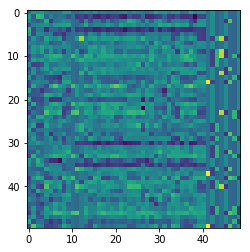

In [5]:
y = model_data.overall
X = model_data.drop('overall', axis = 'columns')
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

## I have an error with my version on sklearn where I cannot call sub-pipelines

model_pipeline = Pipeline([
    ('standardize', StandardScaler()),
#    ('Ridge Regression', Ridge(alpha=0.5,fit_intercept=False))   
])

X_ss = model_pipeline.fit_transform(X=X)

plt.imshow(X_ss[0:50], shape=(10,10))
plt.show()

### Question 3: Do ridge regression (2pt)
Now use Ridge regression with a ridge parameter of 0.5 and report the Validation error on the training set. Use 10-fold cross-validation.  

In [6]:
model_pipeline_2 = Pipeline([
    ('standardize', StandardScaler()),
    ('Ridge', Ridge(alpha=0.5,fit_intercept=True))   
])

cv_scores = cross_val_score(model_pipeline_2, 
                           X, 
                           y, 
                           cv = 10, 
                           scoring = 'neg_mean_squared_error')

print(f"CV error: {-cv_scores.mean()}")

CV error: 1.5580141984902511


### Question 4: Test Error (3pt)
Now test how the ridge model, fitted to the whole training set, on how it performs on the Test data set. Because you wrote a pipeline to perform the preprocessing steps, you shouldn't have to worry about preprocessing the test data.


Report the mean squared error on the test data - along with the 95% confidencen interval, determined with the central limit theorem. What proportion of the variance in the test scores have you predicted (+ CI)? 

In [7]:
def confidence_interval(data):

    n = data.size
    t_quantile = t.ppf(1-0.05/2, df=n-1)
    estimated_mean = data.mean()
    # Note, np.std divides by n and not n-1
    # Force it to apply the correct formula by ussing ddof=1
    # Alternaively, you can use scipy.stats.sem to compute
    #The standard error
    estimated_se = data.std(ddof=1)/np.sqrt(data.size)
    bounds = estimated_mean + t_quantile*estimated_se*np.array([-1,1])

    
    return estimated_mean, bounds

model_4 = model_pipeline_2.fit(X,y)

y_pred = model_4.predict(test.drop('overall', axis = 'columns'))


mse_4, bounds = confidence_interval((y_pred - test['overall'])**2)


print(mse_4)
print(bounds)

ValueError: Found input variables with inconsistent numbers of samples: [2500, 500]

### Question 5: Tune the ridge parameter (3pt)
Now use 10-fold CV on the training set to determine a good setting for the regularization coefficient. Perform the search in log-space, going from $\lambda = \exp(-8), \cdots, \exp(3)$ in steps of 15. Plot the mean squared error as a function of $log(\lambda)$. 

Written answer:  What does this tell you about regularization in this model?
It looks like the optimal regularization coefficient is between exp(2)-exp(4).  

[1.55839516 1.5583947  1.55839343 1.55838998 1.55838063 1.55835535
 1.5582876  1.55811045 1.5576768  1.55679198 1.55591206 1.56042092
 1.60205046 1.8075371  2.45777698]


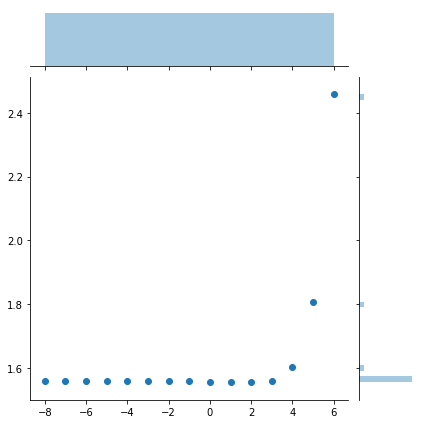

In [8]:
### Steps of 15 makes no sense when the distance between exp(−8) and exp(3) is ~20
# You must mean 15 steps?
al = np.arange(-8,7)
param_grid = {
    'Ridge__alpha': np.exp(al)
}

search = GridSearchCV(model_pipeline_2,
                      param_grid,
                      n_jobs=-1,
                      cv=10, 
                      scoring='neg_mean_squared_error')
search.fit(X,y)

scores = -search.cv_results_['mean_test_score']

print(scores)
sns.jointplot(x=al, y=scores)


### Question 6: Ridge regression with a more complex model - containing all 2-nd order interactions (2pt)
Give how well the model with all quadratic interactions worked the last time, your boss now wants to see if you can fit this model with all quadratic interaction terms to the data. 
Build a design matrix with all quadratic terms and 2-way interactions and then standardize them.  You can very easily do this by altering your pipeline.

Check how many regressors you have. Explain why you have this many terms. 

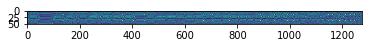

In [9]:
model_pipeline_3 = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('standardize', StandardScaler())
])

X_ss = model_pipeline_3.fit_transform(X=X)

plt.imshow(X_ss[0:50])
plt.show()

### Question 7: Tune the Ridge coefficient for the 2nd-order model   (3pt)
Now use 10-fold CV on the training set to determine a good setting for the regularization coefficient. Perform the search in log-space, going from $\lambda = \exp(-8), \cdots, \exp(3)$ in steps of 15. Plot the mean squared error as a function of $log(\lambda)$. 

Written answer: What does the shape of the curve (as compared to the answer to Question 5) tell you about this model? What is the best regularization?
The curve seems to follow a quadratic form. It amplifies the effects of the coefficients on the loss, making it obvious that exp(2) is probably the best performing result when it comes to trainging error.

[1.21372187 1.14023746 1.05093787 0.96545545 0.89475271 0.83413183
 0.77837142 0.72971005 0.69208048 0.66839131 0.6639495  0.68702233
 0.75265529 0.88405871 1.09544064]


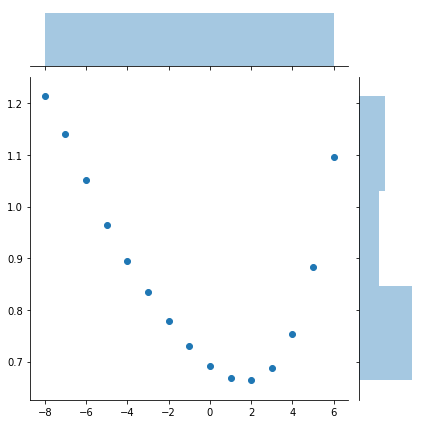

In [10]:
model_pipeline_3 = Pipeline([
    ('poly', PolynomialFeatures()),
    ('standardize', StandardScaler()),
    ('Ridge', Ridge(fit_intercept=True))
])

search = GridSearchCV(model_pipeline_3,
                      param_grid,
                      n_jobs=-1,
                      cv=10, 
                      scoring='neg_mean_squared_error')
search.fit(X,y)

scores_2 = -search.cv_results_['mean_test_score']


print(scores_2)
sns.jointplot(x=al, y=scores_2)

### Question 8: Test error  (2pt)
Report proportion of variance predicted + the 95% confidence for the 2nd-order model with the best regularization parameter, when you fit it on the entire training set. 




In [11]:
test_y = np.array(test['overall']).reshape(-1, 1)
grid_pred = search.best_estimator_.predict(test.drop('overall', axis = 'columns'))

print("Explained Variance Score: ",explained_variance_score(test_y,grid_pred))



mse_8, bounds = confidence_interval((grid_pred - test_y)**2)

print("Estimated MSE:",mse_8 )
print("95% Confidence Bounds: ", bounds)

Explained Variance Score:  0.9863723722840084
Estimated MSE: 102.56525264194413
95% Confidence Bounds:  [102.01380599 103.1166993 ]


### Question 9: Fine-tuning (2 pt)
That's pretty impressive! 

Now, your boss thinks that you could slightly improve your test error by fine-tuning your ridge parameter on the test set for the full model fit. Your boss instructs you to combine the training and test sets, refit the model, and then re-test on the test set.

Would you predict that a smaller or bigger regularization factor would do better? What do you think of this procedure? Is this a reliable procedure for assessing model fit?  Answer in no more than 5 sentences.

I think a smaller regularization parameter would do better. This is because the ridge regression parameter is meant to sacrifice training error for testing error. Meaning, the larger the regularization parameter the larger the training loss but the higher expected test loss. So if we train the model, including the test data, we will definitely be sacrificing test accuracy. I wouldn't recommend this, but I could be wrong.

---
* Write your code in the cells provided.  Where appropirate, enter markdown to answer questions.
* Delete your output before submitting and ensure that the code works when executed sequentially
* Submit this notebook to OWL.

In [ ]:
model_pipeline_4 = Pipeline([
    ('poly', PolynomialFeatures()),
    ('standardize', StandardScaler()),
    ('Ridge', Ridge(fit_intercept=True))
])

search = GridSearchCV(model_pipeline_4 ,
                      param_grid,
                      n_jobs=-1,
                      cv=10, 
                      scoring='neg_mean_squared_error')
X_9 = model_data_last.drop('overall', axis = 'columns')
y_9 = model_data_last['overall']
search.fit(X_9,y_9)

scores_2 = -search.cv_results_['mean_test_score']


print(scores_2)
sns.jointplot(x=al, y=scores_2)

#-----
last_y = np.array(model_data_last['overall']).reshape(-1, 1)
grid_pred = search.best_estimator_.predict(model_data_last.drop('overall', axis = 'columns'))

print("Explained Variance Score: ",explained_variance_score(last_y,grid_pred))



mse_9, bounds = confidence_interval((grid_pred - last_y)**2)

print("Estimated MSE:",mse_9)
print("95% Confidence Bounds: ", bounds)